# LangGraph Visualization

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from schema import Plan, File, TaskPlan, ImplementationTask, State
from prompt import PlannerPrompt , ARCHITECT_PROMPT ,CODER_SYSTEM_PROMPT
from langgraph.graph import StateGraph, END ,START
from langchain.globals import set_verbose, set_debug
from tools import read_file, write_file, list_files, get_current_directory, create_react_agent, init_project_root
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool

load_dotenv()
init_project_root()

'/Users/samakshmehra/Desktop/cursor clone /generated_project'

## Define the State and Agents

In [4]:
graph = StateGraph(State)

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

def planneragent(State):
    userprompt = State["user_prompt"]
    Plannerllm = llm.with_structured_output(Plan)
    prompt = PlannerPrompt.format(user_prompt=userprompt)
    response = Plannerllm.invoke(prompt)
    return {"plan": response}

def architectagent(State):
    plan = State["plan"]
    Architectllm = llm.with_structured_output(TaskPlan)
    prompt = ARCHITECT_PROMPT.format(plan=plan)
    response = Architectllm.invoke(prompt)
    return {"task_plan": response, "current_step": 0}

def coderagent(State):
    task_plan = State["task_plan"]
    current_step = State.get("current_step", 0)
    
    if current_step >= len(task_plan.implementation_steps):
        return {"completed": True}
    
    current_task = task_plan.implementation_steps[current_step]
    
    existing_content = read_file.run(current_task.filepath)
    user_prompt = (
        f"Task: {current_task.task_description}\n"
        f"File: {current_task.filepath}\n"
        f"Existing content:\n{existing_content}\n"
        "Use write_file(path, content) to save your changes."
    )
    
    coder_tools = [read_file, write_file, list_files, get_current_directory]
    react_agent = create_react_agent(llm, coder_tools)

    react_agent.invoke({"messages": [{"role": "system", "content": CODER_SYSTEM_PROMPT},
                                     {"role": "user", "content": user_prompt}]})

    return {"current_step": current_step + 1}

def should_continue(State):
    return "coder" if not State.get("completed", False) else END

## Build the Graph Structure

In [5]:
graph.add_node("Planner", planneragent)
graph.add_node("Architect", architectagent)
graph.add_node("Coder", coderagent)

graph.add_edge(START, "Planner")
graph.add_edge("Planner", "Architect")
graph.add_edge("Architect", "Coder")
graph.add_conditional_edges("Coder", should_continue, {"coder": "Coder", END: END})

## Compile and Visualize the Graph

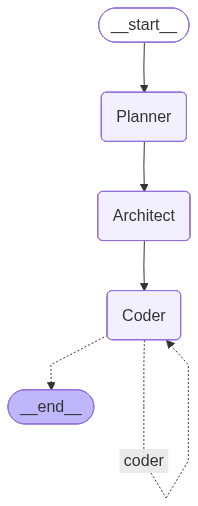

In [15]:
CursorAgent = graph.compile()

# Visualize the graph
from IPython.display import Image
Image(CursorAgent.get_graph().draw_mermaid_png())
